# Génération de mélodies chinoises avec un LSTM (dataset "han")

In [17]:
import os
import music21 as m21
import json
from datetime import datetime
from preprocessing import *
from training import *

### Paramètres

In [18]:
DATASET_PATH = "../data/han/original_songs"
SAVE_DIR_ENCODED_SONGS = "../data/han/encoded_songs"

SEQUENCE_LENGTH = 64
FILE_DATASET_PATH = "../data/han/file_dataset"
MAPPINGS_PATH = "../data/han/mapping.json"

NUM_UNITS = [256]
LOSS = "sparse_categorical_crossentropy"
LEARNING_RATE = 0.001
EPOCHS = 10
BATCH_SIZE = 64

MODEL_PATH = "../data/han/model_RNN_LSTM.keras"

MAPPING_PATH = "../data/han/mapping.json"
SAVE_GENERATED_MELODIES_DIR = "../generated_melodies/RNN-LSTM/han"
seed = "55"

## Préparation des données

* Chargement des musiques
* Enlever notes plus courtes que des double croches
* Enlever les musiques vides
* Transposer tout en Do majeur (La mineur)
* Encoder les musiques en string, tout mettre dans un fichier texte et sauvegarder l'équivalence (mappings)

In [19]:
print("loading data...")
songs = load_songs(DATASET_PATH, 10000)
print(len(songs),"songs loaded")

loading data...
1223 songs loaded


Enlever durées non acceptables (notes plus courtes que double croche) et musiques vides

In [20]:
print("avant filtrage :", len(songs))
for song in songs:
    if not has_acceptable_durations(song, ACCEPTABLE_DURATIONS):
        songs.remove(song)
    if len(song.recurse().getElementsByClass(m21.note.Note)) == 0:
        songs.remove(song)
print("après filtrage :", len(songs))

avant filtrage : 1223
après filtrage : 1091


Transposer en do majeur

In [21]:
transposed_songs = []
for song in songs:
    transposed_songs.append(transpose(song))

Encoder les musiques en format fichier texte

In [22]:
encoded_songs = []
for song in transposed_songs:
    encoded_songs.append(encode_song(song))

sauvegarde dans un fichier texte

In [23]:
for i, encoded_song in enumerate(encoded_songs):
    save_path = os.path.join(SAVE_DIR_ENCODED_SONGS, str(i))
    with open(save_path, "w") as fp:
        fp.write(encoded_song)

Tout mettre dans un fichier

In [24]:
create_single_file_dataset(dataset_path = SAVE_DIR_ENCODED_SONGS, file_dataset_path=FILE_DATASET_PATH, sequence_length=SEQUENCE_LENGTH)

'74 _ _ _ 69 _ 72 _ 74 _ _ _ 74 _ _ _ 69 _ _ 72 74 _ 79 _ 72 _ 69 _ 67 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _ 67 _ 66 _ 67 _ _ _ 67 _ _ 69 72 _ 74 _ 74 _ _ _ 72 _ 74 _ 67 _ _ _ 62 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _ 74 _ _ _ _ _ _ _ 72 _ _ 69 67 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _ / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / 67 _ _ _ 67 _ _ _ 72 _ 67 _ _ _ 65 _ 62 _ 67 _ 58 _ 60 _ 62 _ _ _ _ _ _ _ 67 _ _ _ 67 _ _ _ 72 _ 67 _ _ _ 65 _ 62 _ 67 _ 58 _ 60 _ 62 _ _ _ _ _ _ _ 72 _ 69 _ 72 _ _ 69 67 _ 72 _ 69 _ 72 _ 67 _ _ _ 65 _ 62 _ 67 _ _ _ _ _ _ _ 62 _ 62 62 62 _ 67 _ 62 _ 60 _ 58 _ 57 _ 55 _ _ _ _ _ _ _ 60 _ 58 _ _ _ 60 _ 62 _ _ _ _ _ _ _ 67 _ _ _ _ _ _ _ 62 _ _ _ 64 _ 62 _ 60 _ _ _ _ _ 64 _ 62 _ 60 _ 58 _ 57 _ 55 _ _ _ _ _ _ _ / / / / / / / / / / / / / / / / / / / / / / / 

Mapping des symboles

In [25]:
songs=load(FILE_DATASET_PATH)
create_mapping(songs, MAPPINGS_PATH) 
mappings, OUTPUT_UNITS = load_json(MAPPINGS_PATH)
print(OUTPUT_UNITS)

45


## Entrainement

In [26]:
inputs, targets = generate_training_sequences(64, songs, mappings)

In [27]:
# build the model
model = build_model(OUTPUT_UNITS, NUM_UNITS, LOSS, LEARNING_RATE)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, 45)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       309,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 45)             │        11,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,813 (1.22 MB)

 Trainable params: 320,813 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# train the model

history = model.fit(inputs, targets, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 223s 56ms/step - accuracy: 0.6731 - loss: 1.1465
Epoch 2/10
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 274s 69ms/step - accuracy: 0.7209 - loss: 0.8678
Epoch 3/10
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 199s 50ms/step - accuracy: 0.7345 - loss: 0.8213
Epoch 4/10
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 247s 62ms/step - accuracy: 0.7385 - loss: 0.8039
Epoch 5/10
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 226s 57ms/step - accuracy: 0.7459 - loss: 0.7723
Epoch 6/10
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 214s 54ms/step - accuracy: 0.7464 - loss: 0.7695
Epoch 7/10
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 209s 52ms/step - accuracy: 0.7549 - loss: 0.7393
Epoch 8/10
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 237s 59ms/step - accuracy: 0.7582 - loss: 0.7266
Epoch 9/10
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 218s 55ms/step - accuracy: 0.7636 - loss: 0.7057
Epoch 10/10
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 269s 68ms/step - accuracy: 0.7676 - loss: 0.6890


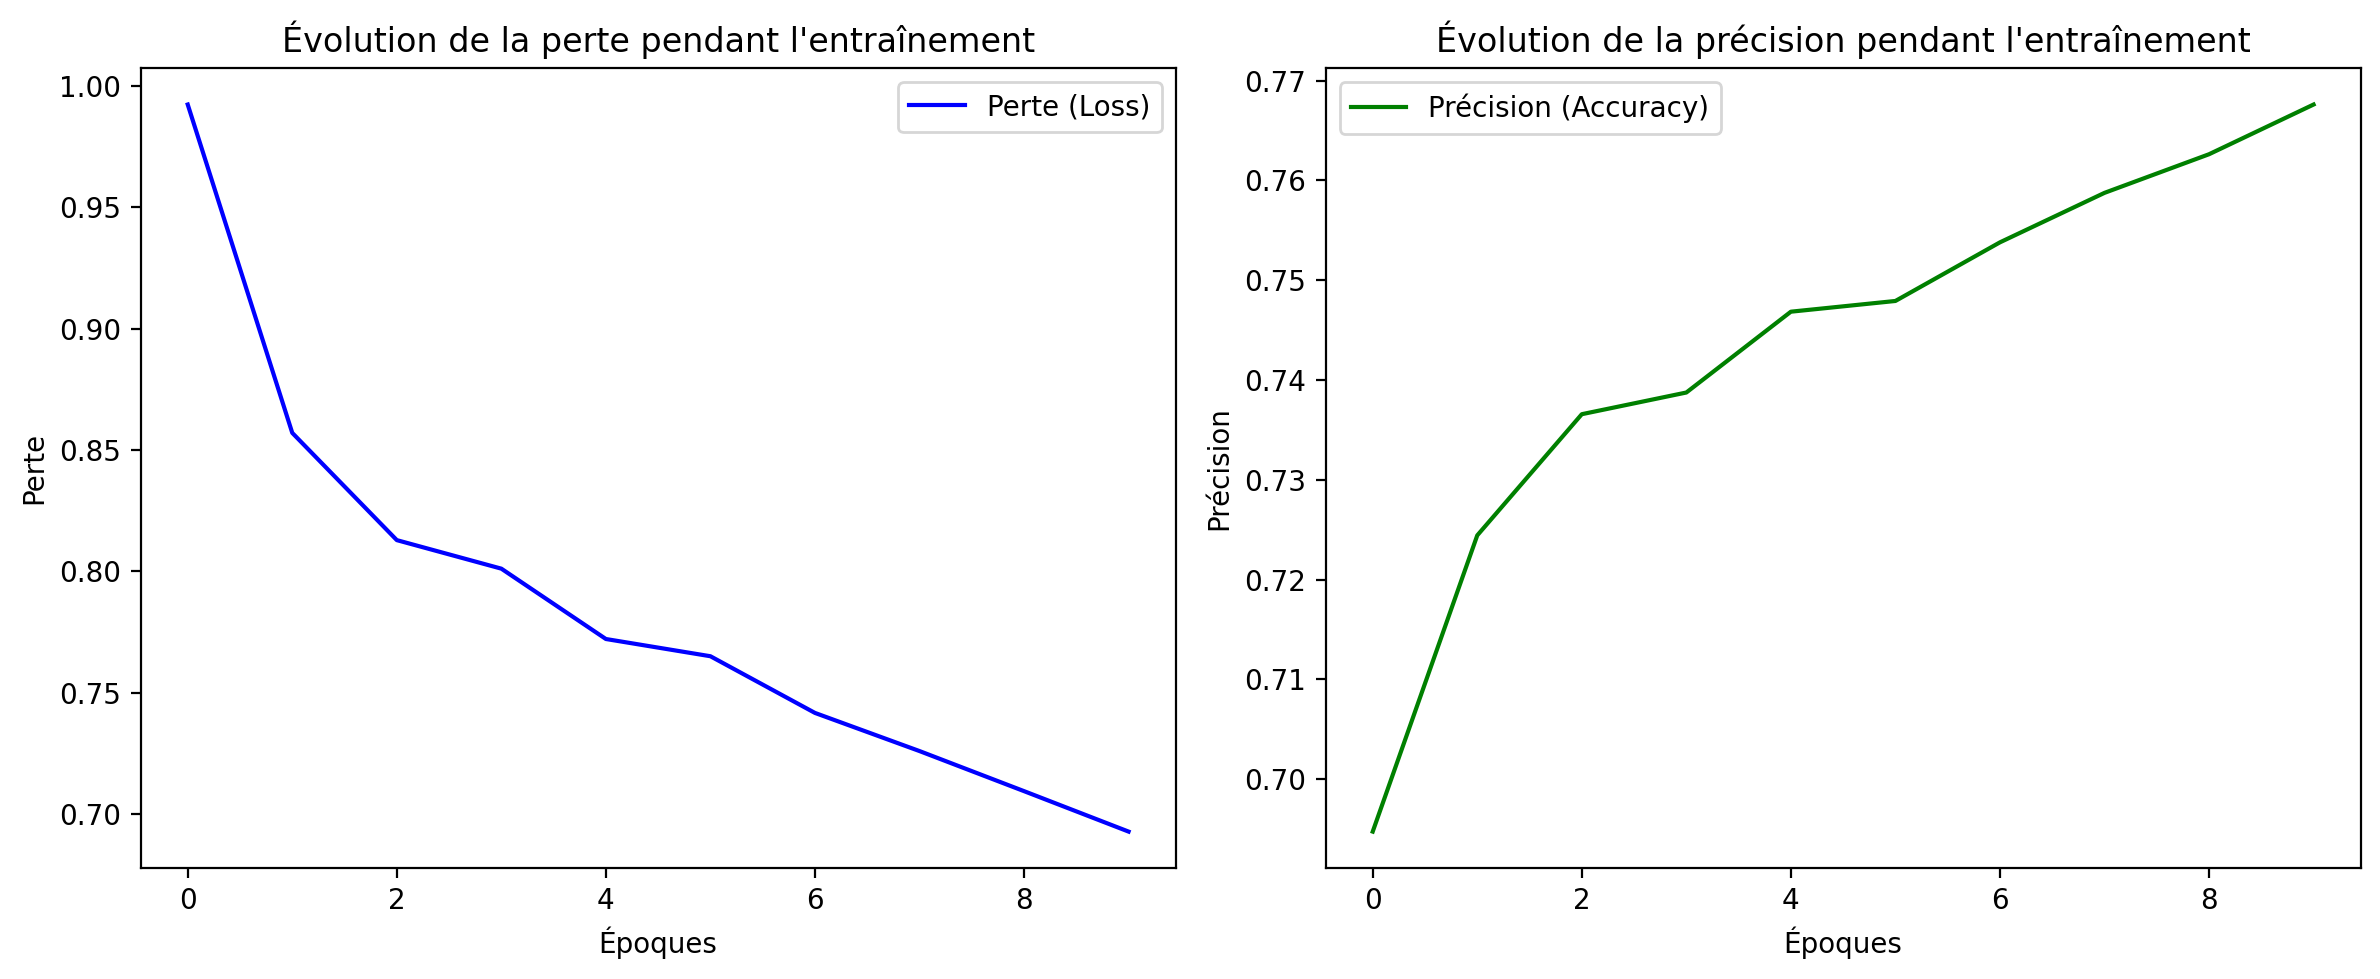

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1 : Loss
axs[0].plot(history.history['loss'], label='Perte (Loss)', color='blue')
axs[0].set_xlabel('Époques')
axs[0].set_ylabel('Perte')
axs[0].set_title("Évolution de la perte pendant l'entraînement")
axs[0].legend()

# Subplot 2 : Accuracy
axs[1].plot(history.history['accuracy'], label='Précision (Accuracy)', color='green')
axs[1].set_xlabel('Époques')
axs[1].set_ylabel('Précision')
axs[1].set_title("Évolution de la précision pendant l'entraînement")
axs[1].legend()

# Affichage
plt.tight_layout()
plt.show()

In [30]:
# save the model
model.save(MODEL_PATH)

## Génération de mélodies

In [31]:
# load model
print(MODEL_PATH)
model = keras.models.load_model(MODEL_PATH)

# start symboles
start_symbols = ["/"] * SEQUENCE_LENGTH

# mappings
with open(MAPPING_PATH, "r") as fp:
    mappings = json.load(fp)

../data/han/model_RNN_LSTM.keras


In [32]:
# Générer 10 mélodies
melodies = []
for _ in range (10):
    melodies.append(generate_melody(model, start_symbols, mappings, seed, 500, SEQUENCE_LENGTH, 0.7))


print(melodies[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

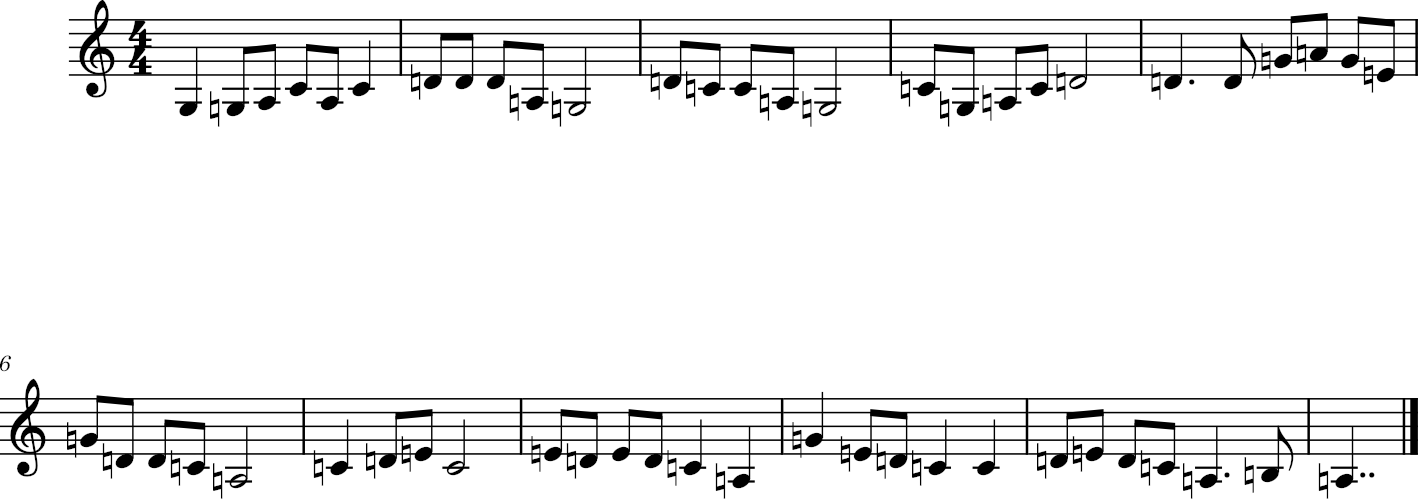

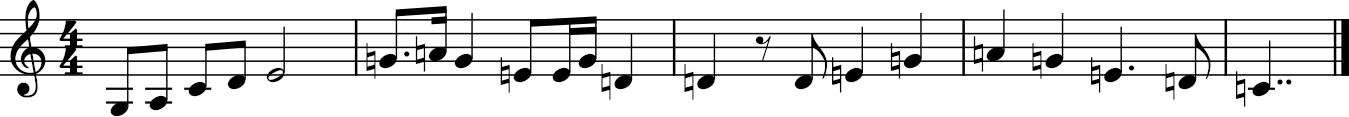

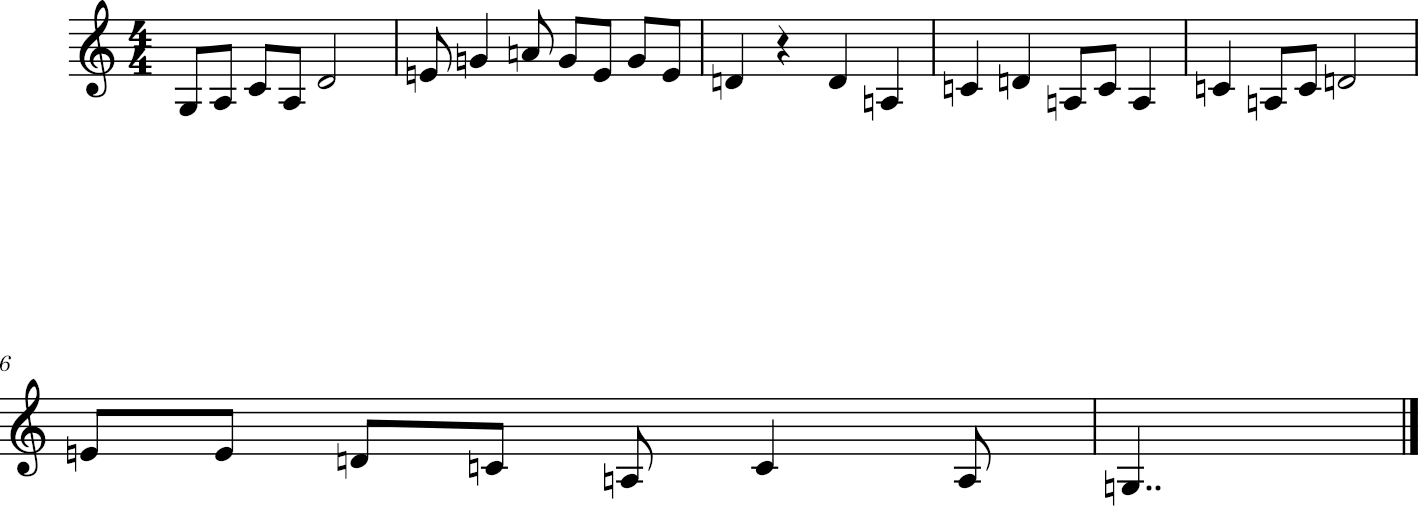

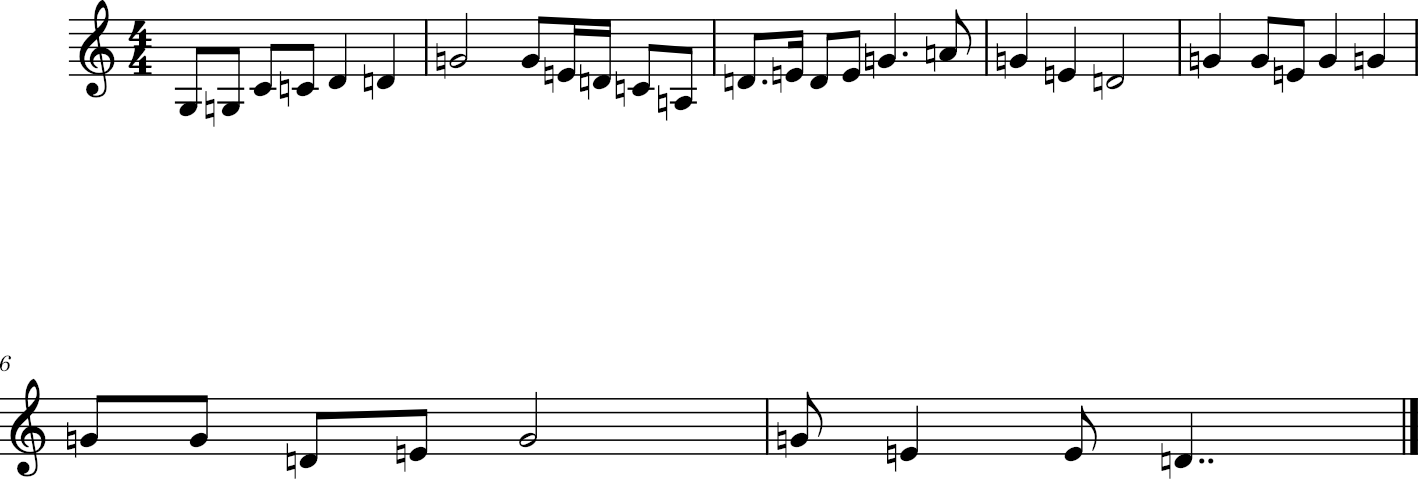

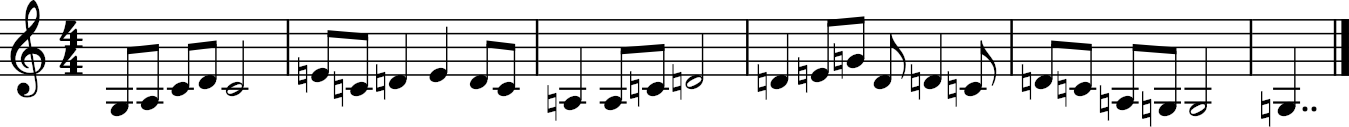

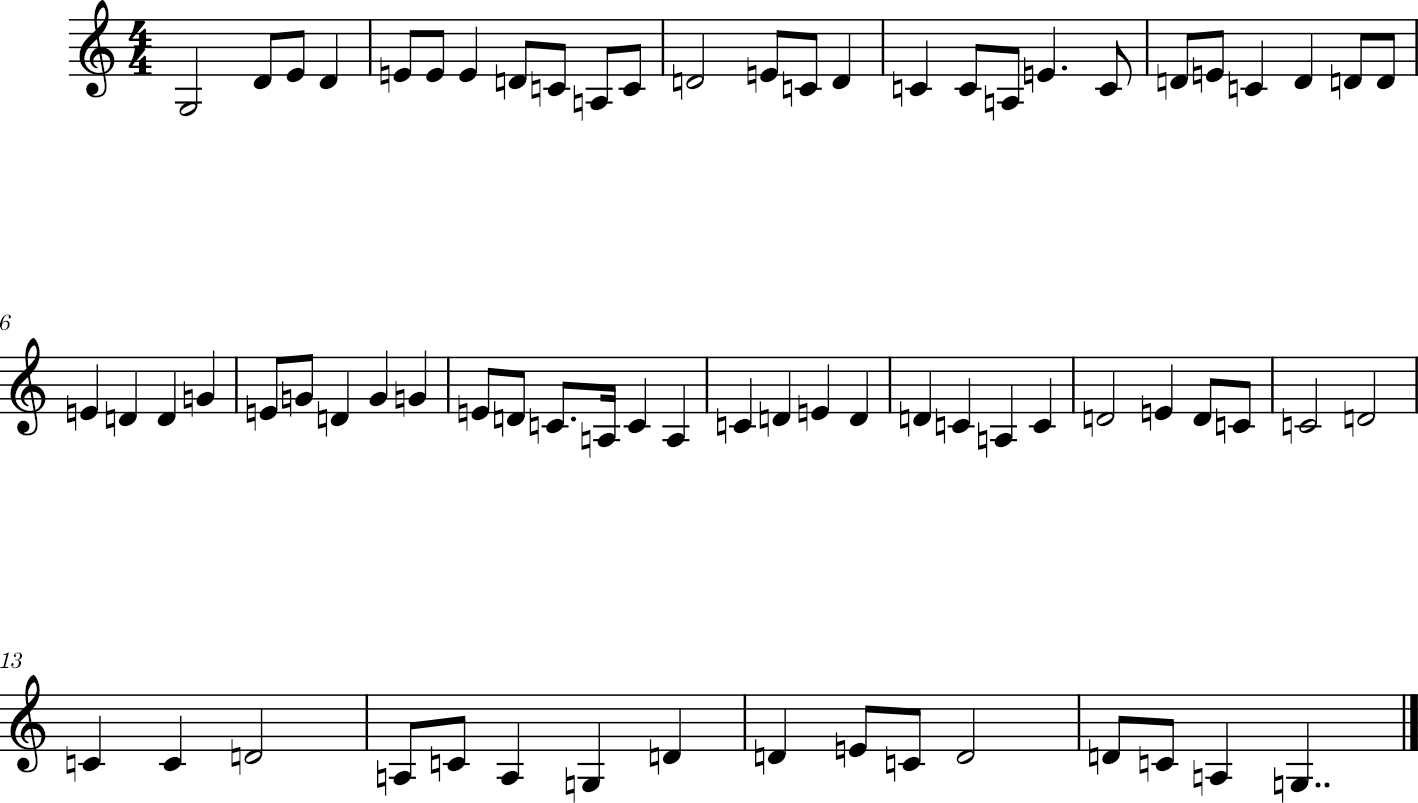

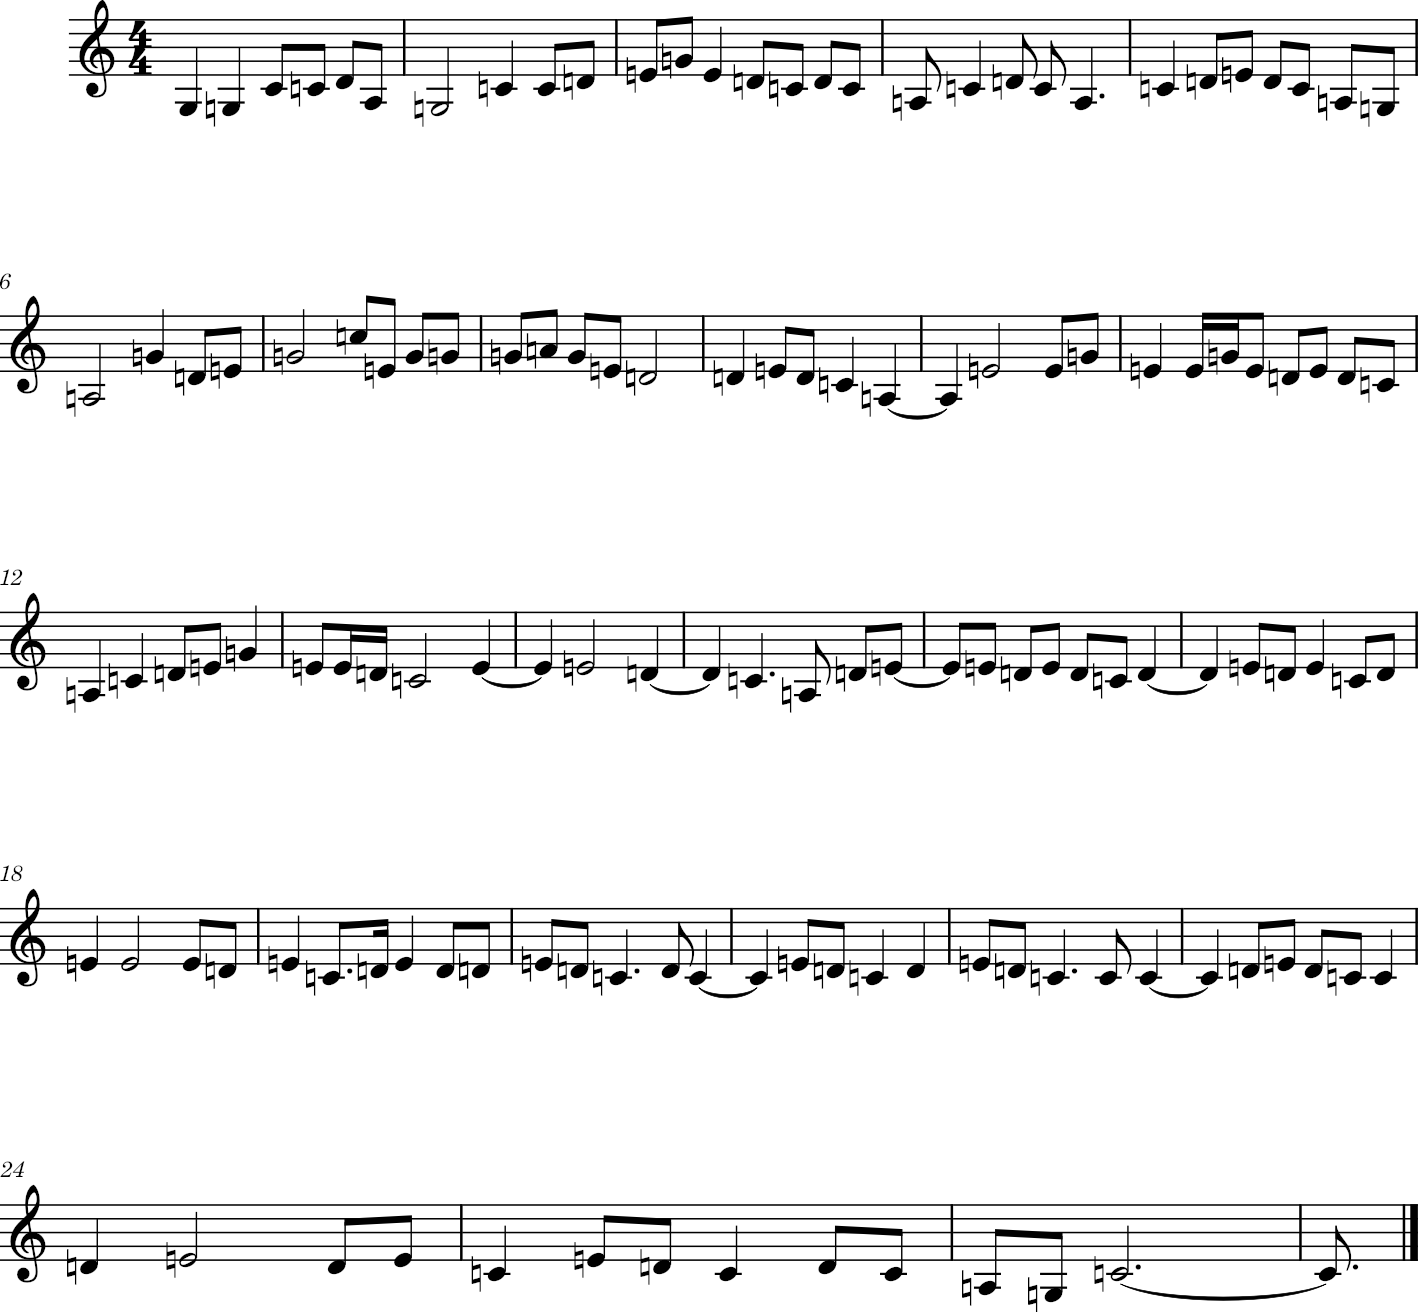

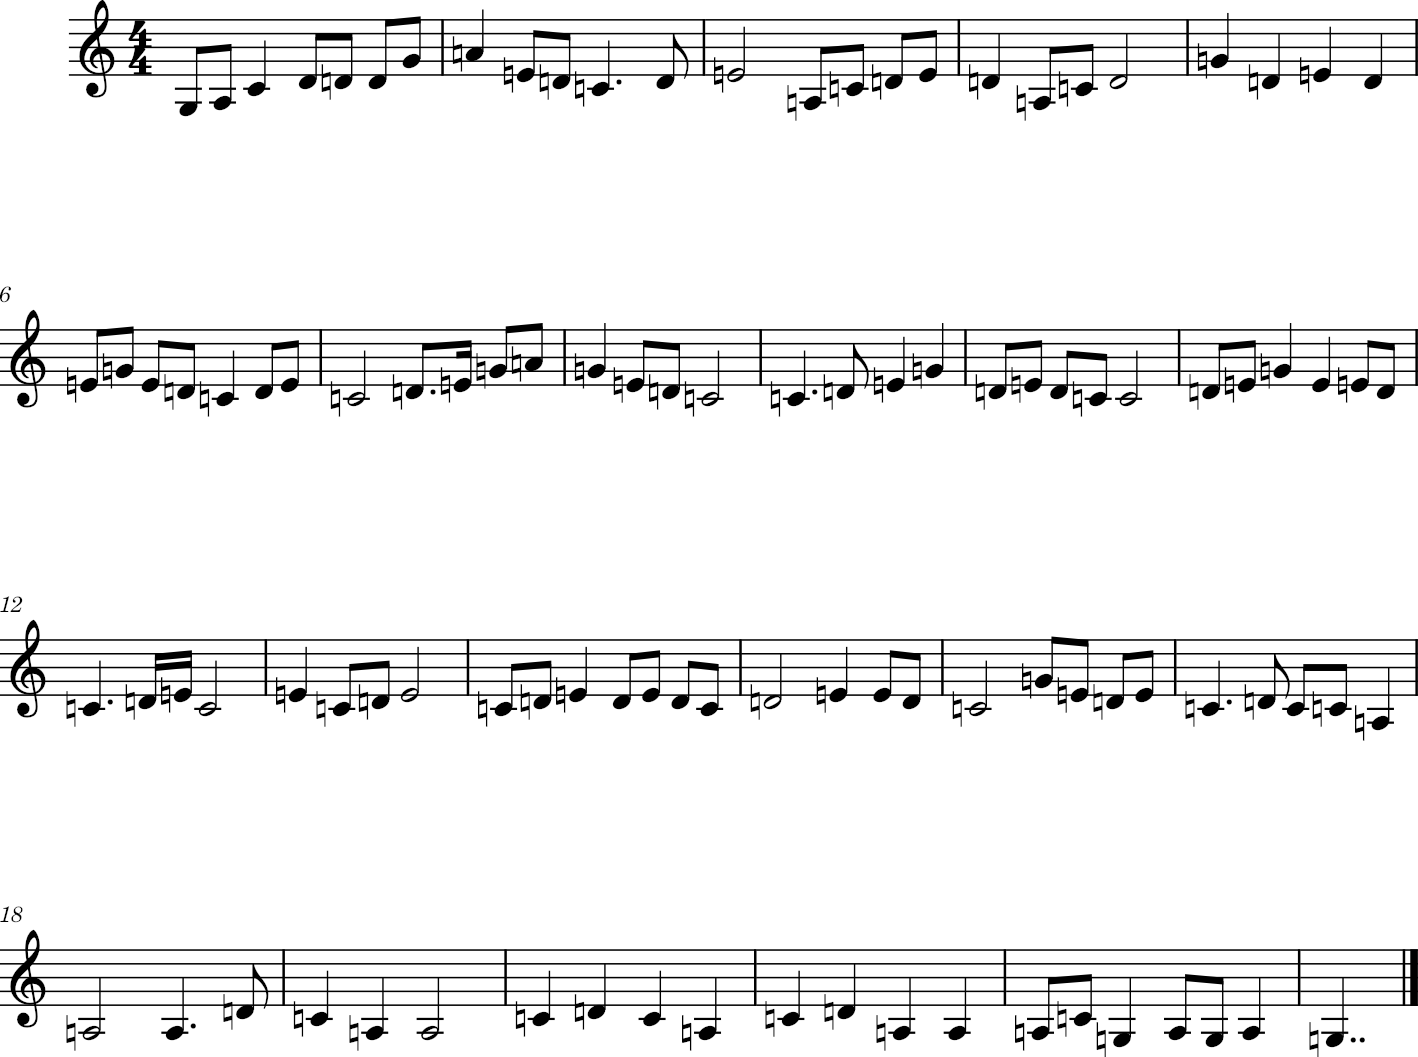

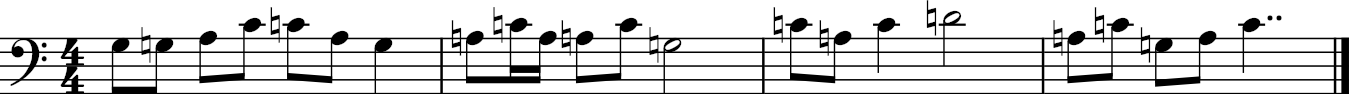

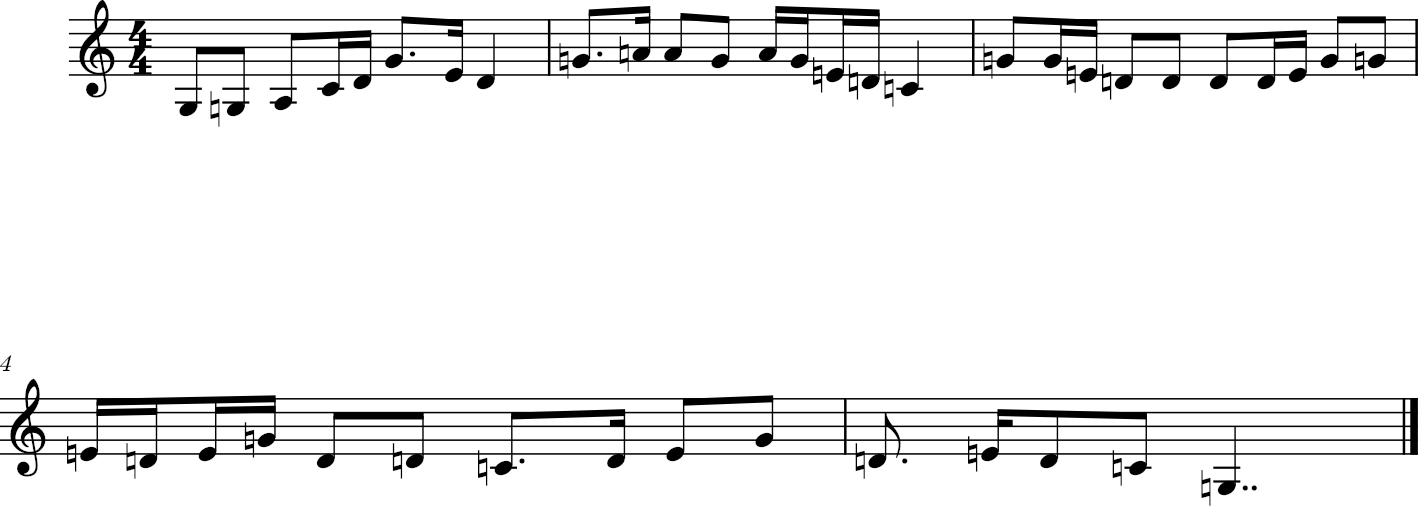

In [33]:
# Les mettre en format midi
songs = []
for i in range(10):
    songs.append(convert_to_midi(melodies[i]))

for song in songs:
    song.show("midi")
    song.show()

In [34]:
# save
timestamp = datetime.now().strftime("%d%m_%H%M%S")  # Format sauvegarde : JJMM_HHMMSS_i
for i in range(10):
    songs[i].write("midi", SAVE_GENERATED_MELODIES_DIR + f"/{timestamp}_{i}.mid")